<a href="https://colab.research.google.com/github/gonzalezjulvez/Projects/blob/main/Formacion/Clasificaci%C3%B3n_de_texto_b%C3%A1sica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de texto básica

En este tutorial demuestra la clasificación de texto a partir de archivos de texto sin formato almacenados en el disco. Entrenaremos a un clasificador binario para realizar análisis de sentimientos en un conjunto de datos IMDB. Al final del notebooks, en el que entrenaremos a un clasificador multiclase para predecir la etiqueta de una pregunta de programación en Stack Overflow.

Este cuaderno entrena un modelo de análisis de sentimientos para clasificar las reseñas de películas como positivas o negativas , según el texto de la reseña. Este es un ejemplo de clasificación binaria, o de dos clases, un tipo de problema de aprendizaje automático importante y ampliamente aplicable.
Utilizará el conjunto de datos de reseñas de películas grandes que contiene el texto de 50.000 reseñas de películas de Internet Movie Database. Estos se dividen en 25,000 revisiones para capacitación y 25,000 revisiones para pruebas. Los conjuntos de entrenamiento y prueba están equilibrados , lo que significa que contienen un número igual de críticas positivas y negativas.




## Cargamos las librerias 

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from pathlib import Path

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


ModuleNotFoundError: No module named 'matplotlib'

## Cargamos el Datasets 

In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz',url,untar=True, cache_dir='.',cache_subdir='')
dataset_dir=os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 12s 0us/step


In [5]:
os.listdir(dataset_dir)

['train', 'README', 'test', 'imdb.vocab', 'imdbEr.txt']

In [10]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['pos',
 'urls_pos.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'neg',
 'urls_unsup.txt',
 'unsup',
 'urls_neg.txt']

Los aclImdb/train/pos y aclImdb/train/neg contienen muchos archivos de texto, cada uno de los cuales es una reseña de una sola película.

In [11]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


Para preparar un conjunto de datos para la clasificación binaria, necesitará dos carpetas en el disco, correspondientes a class_a y class_b . Estas serán las críticas positivas y negativas de películas, que se pueden encontrar en aclImdb/train/pos y aclImdb/train/neg . Como el conjunto de datos de IMDB contiene carpetas adicionales, las eliminará antes de usar esta utilidad.



In [22]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

A continuación, utilizará la utilidad text_dataset_from_directory para crear untf.data.Dataset etiquetado. tf.data es una poderosa colección de herramientas para trabajar con datos. Al ejecutar un experimento de aprendizaje automático, se recomienda dividir su conjunto de datos en tres divisiones: entrenamiento , validación y prueba .

El conjunto de datos de IMDB ya se ha dividido en entrenamiento y prueba, pero carece de un conjunto de validación. Creemos un conjunto de validación usando una división 80:20 de los datos de entrenamiento usando el argumento validation_split continuación.

In [23]:
batch_size = 32
seed= 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('/content/aclImdb/train',
                                                                  batch_size=batch_size,
                                                                  validation_split=0.2,
                                                                  subset='training',
                                                                  seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Como puede ver arriba, hay 25.000 ejemplos en la carpeta de formación, de los cuales utilizará el 80% (o 20.000) para la formación. Como verá en un momento, puede entrenar un modelo pasando un conjunto de datos directamente a model.fit . Si es nuevo en tf.data , también puede iterar sobre el conjunto de datos e imprimir algunos ejemplos de la siguiente manera.



In [25]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print(f"Review {text_batch.numpy()[i]}")
    print(f"Label {label_batch.numpy()[i]}")

Review b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up."
Label 1
Review b'Caution: May contain spoilers...<br /><br />I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for general distribution instead of made for TV.<

Observe que las reseñas contienen texto sin formato (con puntuación y etiquetas HTML ocasionales como). Mostrará cómo manejarlos en la siguiente sección.

Las etiquetas son 0 o 1. Para ver cuáles corresponden a reseñas de películas positivas y negativas, puede verificar la propiedad class_names en el conjunto de datos.



In [26]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Nota: Cuando utilice los argumentos validation_split y subset , asegúrese de especificar una semilla aleatoria o de pasar shuffle=False , para que las divisiones de validación y entrenamiento no se superpongan.


In [30]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [31]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## Preparar datos para entrenar el modelo

La estandarización se refiere al preprocesamiento del texto, generalmente para eliminar la puntuación o elementos HTML para simplificar el conjunto de datos. La tokenización se refiere a dividir cadenas en tokens (por ejemplo, dividir una oración en palabras individuales, dividiéndola en espacios en blanco). La vectorización se refiere a convertir tokens en números para que se puedan alimentar a una red neuronal. Todas estas tareas se pueden realizar con esta capa.

Como vio anteriormente, las reseñas contienen varias etiquetas HTML como \<br /> . Estas etiquetas no serán eliminadas por el estandarizador predeterminado en la capa TextVectorization (que convierte el texto a minúsculas y elimina la puntuación por defecto, pero no elimina el HTML). Escribirás una función de estandarización personalizada para eliminar el HTML.

------------------------------------------------------------------------
Nota: para evitar el sesgo de tren / prueba (también conocido como sesgo de tren / servicio), es importante preprocesar los datos de forma idéntica en el momento del tren y de la prueba. Para facilitar esto, la capa TextVectorization se puede incluir directamente dentro de su modelo, como se muestra más adelante en este tutorial.

In [32]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />',' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
  

A continuación, creará una capa TextVectorization . usará esta capa para estandarizar, tokenizar y vectorizar nuestros datos. Establece output_mode en int para crear índices enteros únicos para cada token. 

Tenga en cuenta que está utilizando la función de división predeterminada y la función de estandarización personalizada que definió anteriormente. También podrá definir algunas constantes para el modelo, como un máximo explícita sequence_length , lo que hará que la capa de secuencias almohadilla o truncar a exactamente sequence_length valores.

In [33]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    standardize = custom_standardization,
    output_mode='int',
    output_sequence_length= sequence_length   
)

A continuación, llamará a adapt para ajustar el estado de la capa de preprocesamiento al conjunto de datos. Esto hará que el modelo cree un índice de cadenas a números enteros.

-------------------------
Nota: es importante que solo uses tus datos de entrenamiento cuando llames a adapt (usar el conjunto de prueba podría filtrar información).

In [40]:
train = raw_train_ds.map(lambda x,y: x)
vectorize_layer.adapt(train)

In [49]:
# Creemos una función para ver el resultado de usar esta capa para preprocesar algunos datos.
def vectorize_text(texts,label):
  text = tf.expand_dims(texts,-1)
  return vectorize_layer(text), label 


In [50]:
# Obtenemos un sample de 10 reseñas y labels de nuestro datasets
text_batch, label_batch = next(iter(raw_train_ds))
first_review ,firts_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label",firts_label)
print("Vectorized review",vectorize_text(first_review, firts_label))

Review tf.Tensor(b"I went to see Fever Pitch with my Mom, and I can say that we both loved it. It wasn't the typical romantic comedy where someone is pining for the other, and blah blah blah... You weren't waiting for the climatic first kiss or for them to finally get together. It was more real, because you saw them through the relationship, rather than the whole movie be about them getting together. People could actually relate to the film, because it didn't seem like extraordinary circumstances, or impossible situations. It was really funny, and I think it was Jimmy Fallon's best performance. All in all... I would definitely recommend it!", shape=(), dtype=string)
Label tf.Tensor(1, shape=(), dtype=int32)
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  10,  426,    6,   67, 3775, 3322,   16,   54, 1611,    3,   10,
          68,  131,   12,   71,  192,  446,    9,    9,  269,    2,  769,
         736,  220,  114,  282,    7,    1,   15,    2,   78,    3, 

In [52]:
print("10 ---> ",vectorize_layer.get_vocabulary()[10])
print("426 ---> ",vectorize_layer.get_vocabulary()[426])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

10 --->  i
426 --->  went
Vocabulary size: 10000


In [54]:
#Como paso final de preprocesamiento, aplicará la capa TextVectorization que creó anteriormente al conjunto de datos de entrenamiento, validación y prueba.
train_ds= raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Estos son dos métodos importantes que debe utilizar al cargar datos para asegurarse de que las E / S no se bloqueen.

**.cache()** mantiene los datos en la memoria después de que se cargan del disco. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrena su modelo. Si su conjunto de datos es demasiado grande para caber en la memoria, también puede usar este método para crear una caché en disco de alto rendimiento, que es más eficiente de leer que muchos archivos pequeños.

**.prefetch()** superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento.

In [55]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creación del modelo

In [77]:
embedding_dim = 16

model = tf.keras.Sequential([
                             layers.Embedding(max_features+1, embedding_dim),
                             layers.Dropout(0.2),
                             layers.GlobalAveragePooling1D(),
                             layers.Dropout(0.2),
                             layers.Dense(1)])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


Las capas se apilan secuencialmente para construir el clasificador:

- La primera capa es una capa de Embedding . Esta capa toma las revisiones codificadas con números enteros y busca un vector de incrustación para cada índice de palabras. Estos vectores se aprenden a medida que se entrena el modelo. Los vectores agregan una dimensión a la matriz de salida. Las dimensiones resultantes son: (batch, sequence, embedding)

- A continuación, una capa GlobalAveragePooling1D devuelve un vector de salida de longitud fija para cada ejemplo promediando la dimensión de la secuencia. Esto permite que el modelo maneje entradas de longitud variable, de la manera más simple posible.

- Este vector de salida de longitud fija se canaliza a través de una capa completamente conectada ( Dense ) con 16 unidades ocultas.

- La última capa está densamente conectada con un solo nodo de salida.


In [78]:
# Compilaremos el modelo con la funcion de perdida y el optimizador

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [79]:
# Entrenamos el modelo

epochs = 10

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 6ms/step - loss: 0.6839 - binary_accuracy: 0.6142 - val_loss: 0.6178 - val_binary_accuracy: 0.7728
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5823 - binary_accuracy: 0.7841 - val_loss: 0.4997 - val_binary_accuracy: 0.8208
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4670 - binary_accuracy: 0.8335 - val_loss: 0.4211 - val_binary_accuracy: 0.8454
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3921 - binary_accuracy: 0.8588 - val_loss: 0.3746 - val_binary_accuracy: 0.8610
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3458 - binary_accuracy: 0.8743 - val_loss: 0.3458 - val_binary_accuracy: 0.8680
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3111 - binary_accuracy: 0.8859 - val_loss: 0.3269 - val_binary_accuracy: 0.8722
Epoch 7/10
625/625 [==============================] - 4s 6ms/ste

In [80]:
# Evaluar el modelo
model.evaluate(test_ds)

782/782 [==============================] - 1s 1ms/step - loss: 0.3103 - binary_accuracy: 0.8738


[0.3103112578392029, 0.8737999796867371]

## Cree una gráfica de precisión y pérdida a lo largo del tiempo

model.fit() devuelve un objeto History que contiene un diccionario con todo lo que sucedió durante el entrenamiento:



In [81]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

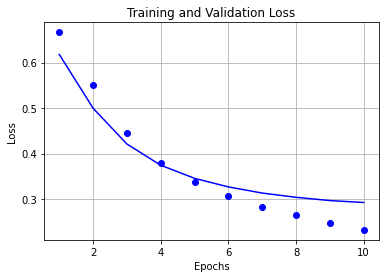

In [82]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, loss,'bo', label='Training loss')
plt.plot(epochs, val_loss,'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

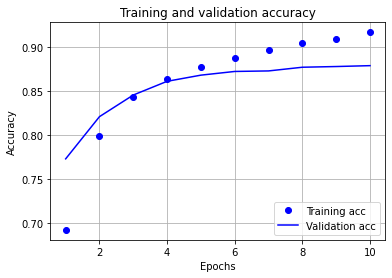

In [83]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

En este gráfico, los puntos representan la pérdida y la precisión del entrenamiento, y las líneas continuas son la pérdida y la precisión de la validación.

Observe que la pérdida de entrenamiento disminuye con cada época y la precisión del entrenamiento aumenta con cada época. Esto se espera cuando se usa una optimización de descenso de gradiente; debe minimizar la cantidad deseada en cada iteración.

Este no es el caso de la pérdida de validación y la precisión; parecen alcanzar su punto máximo antes que la precisión del entrenamiento. Este es un ejemplo de sobreajuste: el modelo funciona mejor en los datos de entrenamiento que en los datos que nunca antes había visto. Después de este punto, el modelo sobreoptimiza y aprende representaciones específicas de los datos de entrenamiento que no se generalizan a los datos de prueba.

Para este caso particular, podría evitar el sobreajuste simplemente deteniendo el entrenamiento cuando la precisión de la validación ya no aumente. Una forma de hacerlo es utilizar [tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).



## Guardar el modelo

En el código anterior, aplicó la capa TextVectorization al conjunto de datos antes de alimentar texto al modelo. Si desea que su modelo sea capaz de procesar cadenas sin procesar (por ejemplo, para simplificar su implementación), puede incluir la capa TextVectorization dentro de su modelo. Para hacerlo, puede crear un nuevo modelo utilizando los pesos que acaba de entrenar.




In [84]:
export_model = tf.keras.Sequential([
                                    vectorize_layer,
                                    model,
                                    layers.Activation('sigmoid')
])

export_model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
                     optimizer='adam',
                     metrics =['accuracy'])

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 10s 12ms/step - loss: 0.3172 - accuracy: 0.8688
0.8737999796867371


# Inferencia del modelo

Para obtener predicciones para nuevos ejemplos, simplemente puede llamar model.predict() .



In [87]:
examples = [
  "It is the best movie I have seen, I liked everything.",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.76505446],
       [0.45269707],
       [0.37022758]], dtype=float32)